# KFold
- 데이터셋을 k개의 동일 크기 부분(Fold)나눠서 K번 반복하여 하나의 폴드를 검증용으로 사용하고 나머지 k-1개의 폴드를 학습용으로 사용
- 모든 폴드를 한번은 검증용으로 포함이 되고 k-1개를 학습용으로 사용
- 데이터의 수가 적을 때 모델의 성능을 안정적으로 평가 할 수 있는 방법

- 매개변수
    - n_splits
        - 기본값 : 5
        - 폴드의 개수를 지정
        - 최소값은 2
    - shuffle
        - 기본값 : False
        - 데이터를 분할하기 전에 섞을지 지정
        - True로 변경하게 되면 폴드가 랜덤하게 구성
    - random_state
        - 기본값 : None
        - shuffle이 True인 경우에 사용
        - 랜덤 시드 고정
- 속성
    - n_splits
        - 분할된 폴드의 개수
- 메서드
    - spilt(x, y)
        - 학습용/검증용 인덱스를 생성
        - 반복문을 이용하여 (train_index, test_index)로 변환하여 사용

- 장점
    - 데이터를 폴드화 해서 학습/검증용으로 사용하기 때문에 데이터가 낭비가 없다.
    - 일반적으로 사용하던 train_test_spilt보다 성능 평가가 안정적(설명이 충분하다.)
- 단점
    - K번의 학습 -> K번의 예측 -> K번의 평가  ==> 계산이 늘어남 -> 시간증가
    - 데이터의 크기가 크다면 시간이 증가

- 변형 KFold 클래스
    - stratifiedKFold : 분류 문제에서 클래스의 비율을 유지하여 분할
    - GroupKFold : 그룹 단위로 데이터를 나눠 그룹이 학습/검증이 동시에 들어가지 않도록 보장
    - RepeatedKFold : KFold를 여러번 반복하여 평가 안정성을 강화

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import classification_report, r2_score

In [17]:
# pipeline + GridSearchCV + KFold를 사용하여 분류 문제 해결
# iris 데이터를 로드
iris = pd.read_csv("../data/iris.csv")
iris.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [18]:
iris['target'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [19]:
# target 데이터를 0, 1, 2로 데이터를 변경
iris['target'] = iris['target'].map(
    {
        'Iris-setosa' : 0,
        'Iris-versicolor' : 1,
        'Iris-virginica' : 2
    }
)

In [20]:
x = iris.drop('target', axis=1).values
y = iris['target'].values

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(
    x, y,
    random_state=42,
    test_size=0.2,
    stratify=y
)

In [22]:
# KFold를 이용해서 데이터 분할
# 분류 모델 -> target의 비율 1:1:1 -> 비율을 맞춰서 폴드화
# stratifiedKFold를 이용
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
# pipeline 생성 -> 학습 -> Scaler 생성하고 fit()을 이용하여 범위를 지정하고 transform()을 이용해서 스케일링을 하고 모델에 학습을 시킨다.
# 예측(predict()) - >생성된 Scaler를 사용하여 검증 데이터를 transform()을 이용해서 스케일링된 학습된 모델에 predict() 함수를 이용하여 예측값을 반환
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('svc', SVC(probability=True, random_state=42))
    ]
)

In [30]:
# GridSearchCV에서 사용할 파라미터 조합을 생성
# pipeline을 이용하여 Grid를 사용하면 매개변수의 이름을 수정할 필요가 있다.
# pipeline에서 사용할 모델에 (이름 + __ + 매개변수명) 키 겂들을 변경
params = {
    "svc__C": [0.1, 1, 10],
    "svc__gamma": ["scale", "auto"],
    "svc__kernel": ["linear", "rbf"]
}

In [31]:
grid_cls = GridSearchCV(
    estimator= pipe,            # gird에서 사용할 모델은 pipeline으로 만들어진 모델을 사용한다.
    param_grid=params,          # dict 형태로 각 파라미터별 사용할 값 지정
    scoring='accuracy',          # 검증할 때마다 정확도를 이용하여 모델을 평가
    cv = cv_folds,              # 교차 검증 횟수는 KFold의 값들을 이용
    verbose=1,                  # 진행상황을 간단한 로그로 표시
    refit = True,               # 베스트 파라미터를 이용하여 재학습을 한다.
    return_train_score=True,    # 학습 데이터의 성능을 확인한다.
    n_jobs=1                    # 해당 코드를 이용하여 작업 시 사용할 코어는 모두
)

grid_cls.fit(X_train, Y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'svc__C': [0.1, 1, ...], 'svc__gamma': ['scale', 'auto'], 'svc__kernel': ['linear', 'rbf']}"
,scoring,'accuracy'
,n_jobs,1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,copy,True


In [34]:
# print(grid_cls.score(X_test, Y_test))
pd.DataFrame(grid_cls.cv_results_).sort_values(
"mean_test_score", ascending= False
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,param_svc__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.005787,0.005771,0.001446,0.000636,0.1,scale,linear,"{'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__k...",0.958333,1.000000,0.958333,0.958333,1.000000,0.975000,0.020412,1,0.968750,0.968750,0.979167,0.979167,0.968750,0.972917,0.005103
2,0.002344,0.000447,0.000938,0.000200,0.1,auto,linear,"{'svc__C': 0.1, 'svc__gamma': 'auto', 'svc__ke...",0.958333,1.000000,0.958333,0.958333,1.000000,0.975000,0.020412,1,0.968750,0.968750,0.979167,0.979167,0.968750,0.972917,0.005103
6,0.001981,0.000370,0.000744,0.000041,1.0,auto,linear,"{'svc__C': 1, 'svc__gamma': 'auto', 'svc__kern...",1.000000,1.000000,1.000000,0.958333,0.916667,0.975000,0.033333,1,0.968750,0.968750,0.979167,0.979167,0.989583,0.977083,0.007795
4,0.002301,0.000670,0.000835,0.000151,1.0,scale,linear,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",1.000000,1.000000,1.000000,0.958333,0.916667,0.975000,0.033333,1,0.968750,0.968750,0.979167,0.979167,0.989583,0.977083,0.007795
8,0.002579,0.000867,0.001255,0.000444,10.0,scale,linear,"{'svc__C': 10, 'svc__gamma': 'scale', 'svc__ke...",1.000000,0.958333,1.000000,0.958333,0.916667,0.966667,0.031180,5,0.979167,0.958333,0.968750,0.989583,1.000000,0.979167,0.014731
9,0.002414,0.000569,0.001020,0.000459,10.0,scale,rbf,"{'svc__C': 10, 'svc__gamma': 'scale', 'svc__ke...",0.958333,0.958333,1.000000,0.958333,0.958333,0.966667,0.016667,5,0.989583,0.979167,0.968750,0.989583,1.000000,0.985417,0.010623
5,0.002990,0.000691,0.001031,0.000291,1.0,scale,rbf,"{'svc__C': 1, 'svc__gamma': 'scale', 'svc__ker...",0.958333,1.000000,0.958333,0.958333,0.958333,0.966667,0.016667,5,0.979167,0.979167,0.968750,0.979167,0.979167,0.977083,0.004167
7,0.002671,0.000311,0.001028,0.000096,1.0,auto,rbf,"{'svc__C': 1, 'svc__gamma': 'auto', 'svc__kern...",0.958333,1.000000,0.958333,0.958333,0.958333,0.966667,0.016667,5,0.979167,0.979167,0.968750,0.979167,0.979167,0.977083,0.004167
10,0.001734,0.000120,0.000747,0.000141,10.0,auto,linear,"{'svc__C': 10, 'svc__gamma': 'auto', 'svc__ker...",1.000000,0.958333,1.000000,0.958333,0.916667,0.966667,0.031180,5,0.979167,0.958333,0.968750,0.989583,1.000000,0.979167,0.014731
11,0.002030,0.000205,0.000717,0.000040,10.0,auto,rbf,"{'svc__C': 10, 'svc__gamma': 'auto', 'svc__ker...",0.958333,0.958333,1.000000,0.958333,0.958333,0.966667,0.016667,5,0.989583,0.979167,0.968750,0.989583,1.000000,0.985417,0.010623


In [36]:
# pipe + kfold + grid를 이용한 회귀 분석
# csv에 있는 boson 데이터 로드
boston = pd.read_csv("../csv/boston.csv")

In [37]:
x = boston.drop('Price', axis=1).values
y = boston['Price']

In [51]:
# train, test를 나눌때 회귀 분석이기 때문에 계층화 사용하지 않음
X_train, X_test, Y_train, Y_test = train_test_split(
    x, y,
    random_state=42,
    test_size=0.2
)

In [52]:
# 폴드화에서도 계층화도 필요없기 때문에 KFold 사용
cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)

In [53]:
pipe_reg = Pipeline(
    [
        ('stdscaler', StandardScaler()),
        ('svm_reg', SVR())
    ]
)

In [58]:
# SVR() 모델의 파라미터를 C는 [1, 10, 100]
# kernel은 ['rbf', 'linear']
# epsilon은 [0.1, 0.2, 0.5]
# 파라미터 조합

params2 = {
    "svm_reg__C": [1, 10, 100],
    "svm_reg__kernel": ["linear", "rbf"],
    "svm_reg__epsilon" : [0.1, 0.2, 0.5]
}

In [ ]:
# GridSearchCV를 이용하여 최적의 파라미터를 확인
# scoring은 'mean_squared_error'

grid_cls2 = GridSearchCV(
    estimator= pipe_reg,                        
    param_grid=params2,                         
    scoring='neg_mean_squared_error',           
    cv = cv_folds,                              
    verbose=1,                                  
    refit = True,                              
    return_train_score=True,                    
    n_jobs=1                                    
)

grid_cls2.fit(X_train, Y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,estimator,"Pipeline(step...reg', SVR())])"
,param_grid,"{'svm_reg__C': [1, 10, ...], 'svm_reg__epsilon': [0.1, 0.2, ...], 'svm_reg__kernel': ['linear', 'rbf']}"
,scoring,'neg_mean_squared_error'
,n_jobs,1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,copy,True


# PCA(주성분 분석)
- 차원 축소 기법 중 하나 
- 고차원 데이터(피쳐 개수가 많은 데이터)를 상관관계가 없는 새로운 축으로 변환
- 데이터의 분산을 최대한 보존하면서 차원을 줄여서 시각화

- 매개변수
    - n_components
        - 기본값 : None
        - 주성분의 개수 또는 비율 설정
        - None -> 모든 주성분 유지
        - int -> 선택할 주성분의 개수
        - float(0~1) -> 누적 설명 분산 비율을 기준으로 필요한 주성분의 개수를 선택
        - "mle" -> 자동으로 최적 차우너 수 측정 (샘플의 개수 < 피쳐의 개수 인 경우에만 사용이 가능)
    - whiten
        - 기본값 : False
        - 주성분 벡터를 단위 분산으로 정규화을 할지 지정
        - 데이터의 정규화 효과 (일부 모델에서는 사용가능)
    - std_solver
        - 기본값: "auto"
        - 분해 방식 지정
        - "auto" : 데이터의 크기에 따라서 자동 선택
        - "full" : 정확한 SVD 계산 ( 적은 데이터를 사용)
        - "arpack" : 최소 행렬 기반(큰 차원에서 작은 주 성분을 추출 할때 유용하게 사용)
        - "randomized" : 확률적 근사 알고리즘(대규모 데이터에서 유용하게 사용)
- 속성
    - components_
        - 선택된 주성분 벡터
    - explained_variance_
        - 각 주성분이 설명하는 분산값
    - explain_variance_ratio_
        - 각 주성분이 설명하는 분산의 비율
        - 합계가 1에 가까울수록 원래 분산을 잘 보존
    - singular_values_
        - 선택된 주성부에 대응하는 특이값
    - noise_variance_
        - 유지하지 않는 차우너에서의 분산 추정치
- 메서드
    - fit(x, y)
        - 주성부을 학습
    - transform(x)
        - 학습된 주성분 축을 기준으로 하여 새로운 데이터 변환
    - fit_transform(x, y)
        - PCA 학습 + 변환
    - get_covaiance()
        - PCA로 추청된 공분산 행렬 반환
    - get_precision()
        - PCA로 추정된 정밀도 행렬 반환
    

In [60]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [62]:
x = iris.drop('target', axis=1).values
y = iris['target'].values

In [63]:
# PCA 객체 생성
pca = PCA()
x_pca = pca.fit_transform(x)

In [64]:
# 설명된 분산읭 비율 출력
explained_var_ratio = pca.explained_variance_ratio_
explained_var_ratio

array([0.92461621, 0.05301557, 0.01718514, 0.00518309])

In [66]:
# 분산의 비율 누적합 분산의 비율을 생성
cum_var_ratio = np.cumsum(explained_var_ratio)
cum_var_ratio

array([0.92461621, 0.97763178, 0.99481691, 1.        ])

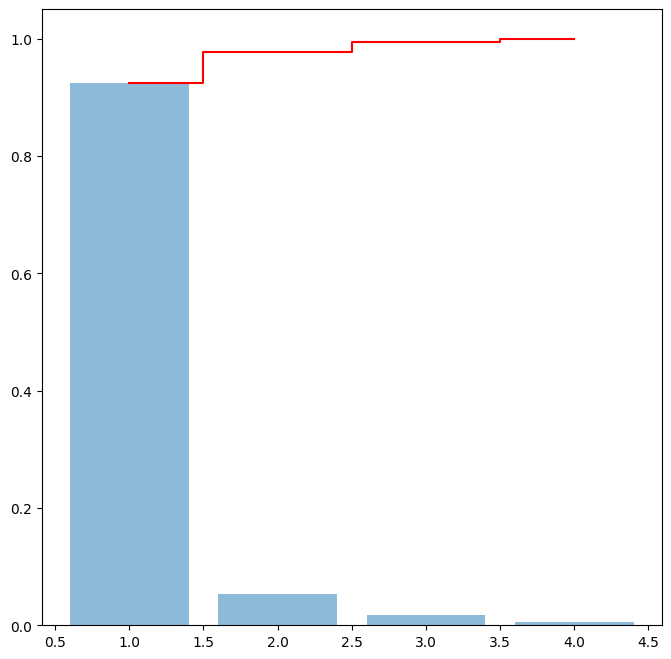

In [ ]:
# 분산의 비율을 그래프 시각화
plt.figure(figsize=(8, 8))

plt.bar(
    range(1, len(explained_var_ratio)+1),
    explained_var_ratio,
    alpha=0.5
)

plt.step(
    range(1, len(explained_var_ratio)+1),
    cum_var_ratio,
    color = 'red',
    where='mid'
)

plt.show()

- 막대 -> 각 주성분이 설명하는 분산의비율
- 선 -> 누적 분산의 비율
- 일반적으로 누적 분산의 비율이 90%~95% 이상이 되는 지점까지 주성분만 선택하는 경우가 다수 -> 차원 축소

- 이 그래프를 보고 iris 데이터에서는 보통 2개의 주성분 만으로도 데이터의 분산의 대부분인 92% 정도 설명이 가능하다

In [78]:
X_train, X_test, Y_train, Y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# KFold를 사용하여 폴드화
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline 생성
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=42)),
    ('svc', SVC(random_state=42, probability=True))
])


# 최적의 파라미터를 찾기 위한 조합
params = {
    "pca__n_components": [None, 2, 3],
    "svc__C": [0.1, 1, 10],
    "svc__gamma": ['scale', 'auto'],
    "svc__kernel": ['linear', 'rbf']
}

# GridSearchCV 사용
grid = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    scoring= 'accuracy',
    cv = cv,
    n_jobs = -1,
    verbose=1,
    refit = True
)

# grid에 fit() 함수를 사용
grid.fit(X_train, Y_train)

print('Best estimator : ', grid.best_estimator_)
print('Best parameter : ', grid.best_params_)
print(classification_report(Y_test, grid.predict(X_test)))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best estimator :  Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(random_state=42)),
                ('svc',
                 SVC(C=0.1, kernel='linear', probability=True,
                     random_state=42))])
Best parameter :  {'pca__n_components': None, 'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



In [79]:
pd.DataFrame(grid.cv_results_).sort_values("mean_test_score", ascending=False)[
    ['mean_fit_time', 'params', 'mean_test_score']
]

,mean_fit_time,params,mean_test_score
0,0.008684,"{'pca__n_components': None, 'svc__C': 0.1, 'sv...",0.975000
2,0.005906,"{'pca__n_components': None, 'svc__C': 0.1, 'sv...",0.975000
6,0.005525,"{'pca__n_components': None, 'svc__C': 1, 'svc_...",0.975000
4,0.005730,"{'pca__n_components': None, 'svc__C': 1, 'svc_...",0.975000
24,0.006425,"{'pca__n_components': 3, 'svc__C': 0.1, 'svc__...",0.975000
26,0.005380,"{'pca__n_components': 3, 'svc__C': 0.1, 'svc__...",0.975000
28,0.005890,"{'pca__n_components': 3, 'svc__C': 1, 'svc__ga...",0.966667
29,0.007249,"{'pca__n_components': 3, 'svc__C': 1, 'svc__ga...",0.966667
8,0.005750,"{'pca__n_components': None, 'svc__C': 10, 'svc...",0.966667
9,0.006156,"{'pca__n_components': None, 'svc__C': 10, 'svc...",0.966667
